In [1]:
from functools import partial
from pathlib import Path

import jax.numpy as jnp
import typer
from jax import jit, random, vmap

from bpd import DATA_DIR
from bpd.chains import run_inference_nuts
from bpd.io import load_dataset_jax, save_dataset, load_dataset
from bpd.pipelines import init_all_params, logtarget_all_free

In [2]:
import matplotlib.pyplot as plt 

In [5]:
rng_key = random.key(42)

pfpath = Path("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/interim_samples_511_plus.npz")

assert pfpath.exists(), "ellipticity samples file does not exist"

ds_plus = load_dataset(pfpath)

samples_plus = ds_plus["samples"]
_ppp = {
    "lf": samples_plus["lf"],
    "lhlr": samples_plus["lhlr"],
    "e1": samples_plus["e1"],
    "e2": samples_plus["e2"],
}

In [6]:
g1 = ds_plus["hyper"]["g1"]
g2 = ds_plus["hyper"]["g2"]
true_g = jnp.array([g1, g2])
sigma_e = ds_plus["hyper"]["shape_noise"]
sigma_e_int = ds_plus["hyper"]["sigma_e_int"]
mean_logflux = ds_plus["hyper"]["mean_logflux"]
sigma_logflux = ds_plus["hyper"]["sigma_logflux"]
a_logflux = ds_plus["hyper"]["a_logflux"]
mean_loghlr = ds_plus["hyper"]["mean_loghlr"]
sigma_loghlr = ds_plus["hyper"]["sigma_loghlr"]


k1, k2 = random.split(rng_key)
_logtarget = jit(partial(logtarget_all_free, sigma_e_int=sigma_e_int))

# Reshape samples
n_splits = 125
split_size = _ppp["e1"].shape[0] // n_splits
assert split_size * n_splits == ppp["e1"].shape[0], "dimensions do not match"
ppp = {k: jnp.reshape(v, (n_splits, split_size, 300)) for k, v in _ppp.items()}


In [7]:
ppp['e1'].shape

(125, 2560, 300)

In [8]:
# initialize positions randomly uniform from true parameters
k1s = random.split(k1, n_splits)
true_params = {
    "sigma_e": sigma_e,
    "mean_logflux": mean_logflux,
    "sigma_logflux": sigma_logflux,
    "a_logflux": a_logflux,
    "mean_loghlr": mean_loghlr,
    "sigma_loghlr": sigma_loghlr,
}
_init_fnc = partial(
    init_all_params,
    true_params=true_params,
    p=0.1,
)
init_positions = vmap(_init_fnc)(k1s)
init_positions["g"] = jnp.zeros((n_splits, 2))

# setup pipeline
pipe = jit(
    partial(
        run_inference_nuts,
        logtarget=_logtarget,
        n_samples=1000,
        initial_step_size=0.01,
        max_num_doublings=7,
        n_warmup_steps=1000,
    )
)

In [30]:
# jit function quickly
print("JITting function...")
out = pipe(
    k2,
    data={k: v[2] for k, v in ppp.items()},
    init_positions={k: v[2] for k, v in init_positions.items()},
)

JITting function...


In [31]:
out.keys()

dict_keys(['a_logflux', 'g', 'mean_logflux', 'mean_loghlr', 'sigma_e', 'sigma_logflux', 'sigma_loghlr'])

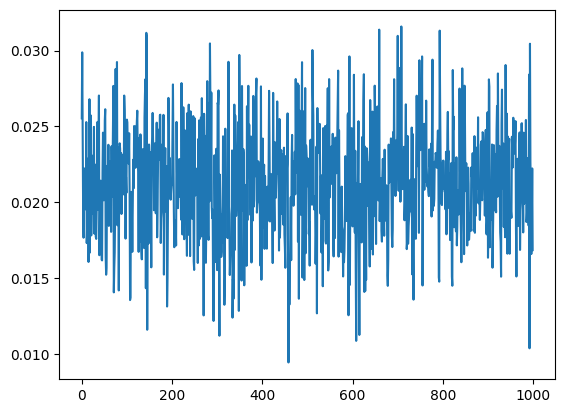

In [32]:
g1 = out['g'][...,0]
plt.plot(g1)

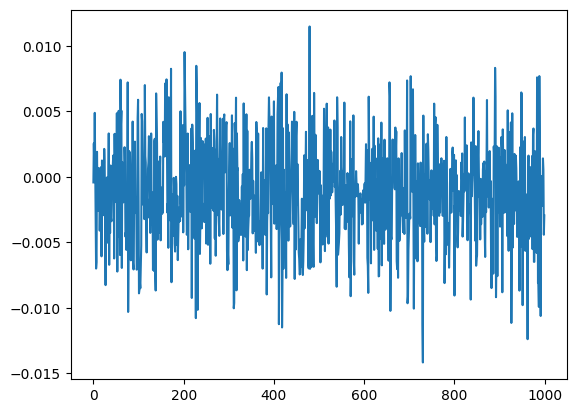

In [33]:
g2 = out['g'][...,1]
plt.plot(g2)

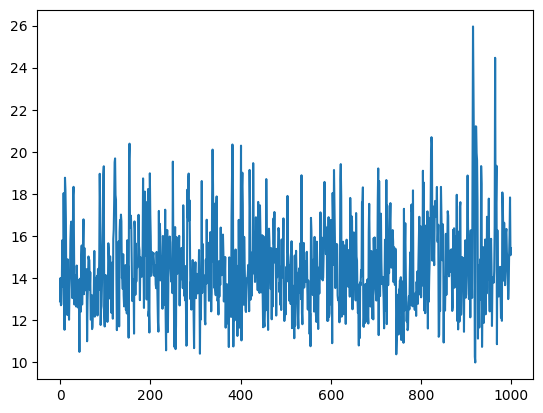

In [34]:
plt.plot(out['a_logflux'])

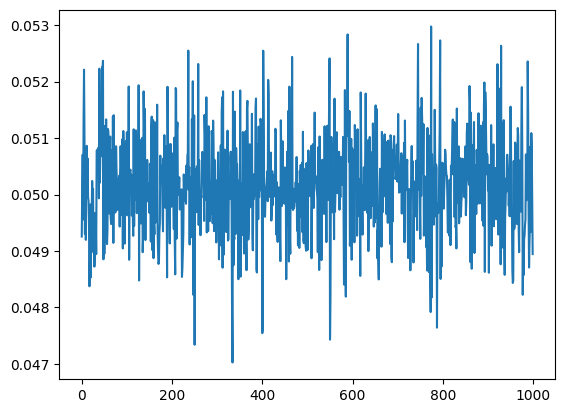

In [35]:
plt.plot(out['sigma_loghlr'])

In [36]:
# # run shear inference pipeline
# k2s = random.split(k2, n_splits)

# print("Running inference...")
# samples_plus = vmap(pipe)(k2s, ppp, init_positions)
# samples_minus = vmap(pipe)(k2s, ppm, init_positions)
# assert samples_plus["g"].shape == (n_splits, n_samples, 2), (
#     "shear samples do not match"
# )
# save_dataset(
#     {
#         "plus": {
#             "g1": samples_plus["g"][:, :, 0],
#             "g2": samples_plus["g"][:, :, 1],
#             **samples_plus,
#         },
#         "minus": {
#             "g1": samples_minus["g"][:, :, 0],
#             "g2": samples_minus["g"][:, :, 1],
#             **samples_minus,
#         },
#     },
#     fpath,
#     overwrite=True,
# )